UCI MACHINE LEARNING HACKATHON - GROUP JAAEHAX (Clinical Dataset)  
Jatin Momaya (jmomaya@uci.edu)  
Arvind Kumar (@uci.edu)  
Aditya Chowdhury (@uci.edu)  
Eric Chou (@uci.edu)  

QUESTION: Is there a correlation between age and likelihood of death?  
HYPOTHESIS: As age increases, likelihood of death also increases.  
OUR APPROACH: We used SQL queries from Microsoft SQL Server Management Studio to get data. We first calculated the age of each patient grouped by individual patient IDs. To calculate the likelihood of death, we decided to set up a 'death score' based on the data we had.

In [5]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

The following cell allowed us to connect to the SQL server and bring the queries that we created in Microsoft SQL Server Management Studio to Python.

In [6]:
#check the drivers for my sql server
'''for drivers in pyodbc.drivers():
       print(drivers)
'''
#connecting to sql server using pydoc

#sql server info
server = 'omop.uci.edu'
database = 'OMOP_DeID'
uid = 'temp_user'
pwd = 'Hackathon1!'

#connecting to sql server using pydoc
conn = pyodbc.connect('DRIVER={SQL Server Native Client 11.0};\
                    Server=' + server + ';\
                    DATABASE=' + database +';\
                    uid=' + uid + ';\
                    pwd=' + pwd)

#create cursor
cursor = conn.cursor()

We began our data collection by filtering in only the patient IDs that were inpatient visits. To do this we used the dbo.visit_occurrence database and specifying the visit_concept_id to '9201' (Inpatient Visits). We initially chose to limit our data to 10,000 patients but later found 2,500 allowed a less clustered end result.
  
The following cell calls the query to load in the age of each patient into a Pandas dataframe. Since we didn't have access to an exact age, we had to calculate patient age by subtracting the year of their last visit to their year of birth.

In [7]:
#age of each patient, x variable 
cursor.execute('WITH maxYearQuery (person_id, Max_Last_Visit_Year) AS\
            (SELECT person_id, MAX(visit_end_date) AS Max_Last_Visit_Year FROM dbo.visit_occurrence GROUP BY person_id)\
            SELECT distinct TOP 2500 da.person_id, year(dc.Max_Last_Visit_Year) AS Last_Visit_Year, db.year_of_birth, (year(dc.Max_Last_Visit_Year)-db.year_of_birth) AS AGE\
            FROM dbo.visit_occurrence da\
            INNER JOIN dbo.person db ON (db.person_id = da.person_id)\
            INNER JOIN maxYearQuery dc ON (dc.person_id = da.person_id)\
            WHERE visit_concept_id = 9201 AND dc.person_id = da.person_id AND (year(dc.Max_Last_Visit_Year)-db.year_of_birth) > 0\
            ORDER BY person_id;')

age = []
for row in cursor:
    age.append((row[0], row[3]))
#convert sql string to pandas dataframe
df_age = pd.DataFrame(age, columns = ['Person_id','Age'])

We decided to calculate our own "death score" in attempts to predict how likely a person is to die depending on various factors. We decided on 4 difference factors and gave them each a different weight so that the maximum total death score would be 1,000.  
  
Our first factor was the total number of conditions reported for each patientID and its death score maximum value was 250.  

Our reasoning behind this factor was that: the more conditions you are diagnosed with, the more serious your case is. We used dbo.condition_occurrence to document the total number of conditions reported per patient. To assign a number between 1-250 (the score) we sorted the data by the total number of conditions reported in ascending order. Since we had a total of 2,500 patients, we divided the data into 250 parts to find 250 even categories of 10 patientIDs. We assigned the number 1 to the first 10 patientIDs, 2 to the second 10 patient IDs, and so on until we reached 250 for the last 10 patientIDs. We ran into some errors due to our dataset containing NaN values so we cleaned the dataset by filling the NaN values by the mean number of conditions.

In [8]:
#DEATH SCORE_PT1
cursor.execute('WITH conditionsQuery (person_id, countConditions)AS(\
                SELECT Distinct person_id, COUNT(DISTINCT condition_concept_id) AS countConditions\
		FROM dbo.condition_occurrence\
		GROUP BY person_id)\
                SELECT DISTINCT TOP 2500 v.person_id, c.countConditions\
                FROM conditionsQuery c\
                RIGHT JOIN dbo.visit_occurrence v ON v.person_id = c.person_id\
                WHERE visit_concept_id = 9201\
                ORDER BY person_id;')

death_score_pt1 = []
for row in cursor:
    death_score_pt1.append((row[0], row[1]))

#convert sql string to pandas dataframe
df_death_score_pt1 = pd.DataFrame(death_score_pt1, columns = ['Person_id', 'countConditions'])
#print(df_death_score_pt1)


##DEATH_WEIGHT PART 1
#setting NaN values of countConditions to the mean # of conditions (56.75190380761523)
cleansed_df_death_score_pt1 = df_death_score_pt1.dropna()
#print((cleansed_df_death_score_pt1.iloc[:,1].values).mean())

df_death_score_pt1['countConditions'] = df_death_score_pt1['countConditions'].fillna(57)


#sorting data frame by countConditions
df_death_score_pt1 = df_death_score_pt1.sort_values(by=['countConditions'])                       

#settingweights from 0 to 250
part1weights = []
count = 0
weight = 1
for x in range(0,2500):
    count += 1
    part1weights.append(weight)
    if(count == 10):
        count = 0
        weight += 1

#adding part1weights array to df_death_score_pt1
df_death_score_pt1['Death Score Pt.1'] = part1weights;
#print(df_death_score_pt1)

Our second factor was the total length of hospitalization reported for each patientID and its death score maximum value was 250.    
  
Our reasoning behind this factor was that: the more days you spend in the hospital, the more serious your case is. We used dbo.cvisit_occurrence to calculate the total number of days each patientID spent in the hospital. To assign a number between 1-250 (the score) we sorted the data by the total length of hospitalization in ascending order. Since we had a total of 2,500 patients, we divided the data into 250 parts to find 250 even categories of 10 patientIDs. We assigned the number 1 to the first 10 patientIDs, 2 to the second 10 patient IDs, and so on until we reached 250 for the last 10 patientIDs. We ran into some errors due to our dataset containing NaN values so we cleaned the dataset by filling the NaN values by the mean length of hospitalization (in days).

In [9]:
#DEATH_SCORE_PT2
cursor.execute('SELECT DISTINCT TOP 2500 v.person_id, SUM(DATEDIFF(DAY, visit_start_date, visit_end_date)+1) AS NumDays\
                FROM dbo.visit_occurrence v\
                WHERE v.visit_end_date <= GETDATE() AND visit_concept_id = 9201\
                GROUP BY person_id\
                ORDER BY person_id;')

death_score_pt2 = []
for row in cursor:
    death_score_pt2.append((row[0], row[1]))

df_death_score_pt2 = pd.DataFrame(death_score_pt2, columns = ['Person_id', 'numDays'])
#print(df_death_score_pt2)

#DEATH_WEIGHT PT2
#setting NaN values of numDays to the mean # of days (10.3986)
cleansed_df_death_score_pt2 = df_death_score_pt2.dropna()
#print((cleansed_df_death_score_pt2.iloc[:,1].values).mean())

df_death_score_pt2['numDays'] = df_death_score_pt2['numDays'].fillna(10)

#sorting data frame by numDays
df_death_score_pt2 = df_death_score_pt2.sort_values(by=['numDays'])                       

#settingweights from 0 to 250
part2weights = []
count = 0
weight = 1
for x in range(0,2500):
    count += 1
    part2weights.append(weight)
    if(count == 10):
        count = 0
        weight += 1

#adding part1weights array to df_death_score_pt1
df_death_score_pt2['Death Score Pt.2'] = part2weights;
#print(df_death_score_pt2)

Our third factor and most important factor was if the patient was dead or alive. Since being dead or alive is a binary condition, we gave dead patients the full score of 350 and alive patients a score of 0.    
  
Our reasoning behind this factor was that: if the patient was actually dead or alive seemed to be the most important part of our 'death score' since it was the only way we knew for sure if the patient's conditions led to death so we assigned it a higher weight. Using dbo.death, we assigned patiets with a death_date to a 'death score' of 350 and those without to a 'death score' of 0.

In [10]:
#DEATH_SCORE_PT3
cursor.execute('SELECT DISTINCT TOP 2500 [visit].[person_id], death.death_date\
                FROM [dbo].[death] death\
                RIGHT JOIN dbo.visit_occurrence visit ON visit.person_id = death.person_id\
                WHERE visit_concept_id = 9201\
                ORDER BY person_id')


death_score_pt3 = []
for row in cursor:
    death_score_pt3.append((row[0], row[1]))

df_death_score_pt3 = pd.DataFrame(death_score_pt3, columns = ['Person_id', 'death_date'])
#print(df_death_score_pt3)

#DEATH_WEIGHT PT3
#setting weight to 0 or 350
part3weights = []
weight = 0
for x in range(0,2500):
    if(df_death_score_pt3['death_date'][x] is None):
        weight = 0
        part3weights.append(weight)
    else:
        weight = 350
        part3weights.append(weight)

df_death_score_pt3['Death Score Pt.3'] = part3weights;
#print(df_death_score_pt3)

Our fourth and final factor was the total number of drugs prescribed for each patientID and its death score maximum value was 150.

Our reasoning behind this factor was that: Due to the multiple drugs being used, and lack of clinical knowledge, we weighted drugs prescribed as lower than the other parts of the death score. We weren't sure whether the more drugs prescribed correlated to a greater severity of condition or a great recovery of the condition. However, we did ensure that the drugs we counted were only prescribed by the doctor, the hospital, or the pharmacy and excluded self-reported drug use by patients. We used dbo.drug_exposure to count the total number of drugs associated with each patient ID and used drug_type_concept_id to filter the type of drugs we counted in our total.  

To assign a number between 1-150 (the score) we sorted the data by the total number of drugs prescribed in ascending order. Since we had a total of 2,500 patients, we divided the data into 150 parts to find 150 even categories of 17 patientIDs. We assigned the number 1 to the first 17 patientIDs, 2 to the second 17 patient IDs, and so on until we reached 150 for the last 17 patientIDs. We ran into some errors due to our dataset containing NaN values so we cleaned the dataset by filling the NaN values by the mean number of drugs prescribed.

In [11]:
#DEATH_SCORE_PT4
cursor.execute('WITH drugsCountQuery (person_id, countDrugConditions)AS(\
	SELECT Distinct person_id, COUNT(DISTINCT drug_concept_id) AS countDrugConditions\
		FROM dbo.drug_exposure\
		WHERE drug_type_concept_id = 44787730 OR drug_type_concept_id = 38000175\
			OR drug_type_concept_id = 38000177\
			OR drug_type_concept_id = 646370719\
			OR drug_type_concept_id = 43542354\
			OR drug_type_concept_id = 38000179\
			OR drug_type_concept_id = 38000180\
		GROUP BY person_id\
        )\
        SELECT DISTINCT TOP 2500 v.person_id, d.countDrugConditions\
        FROM drugsCountQuery d\
        RIGHT JOIN dbo.visit_occurrence v ON v.person_id = d.person_id\
        WHERE visit_concept_id = 9201\
        ORDER BY person_id;')

death_score_pt4 = []
for row in cursor:
    death_score_pt4.append((row[0], row[1]))

df_death_score_pt4 = pd.DataFrame(death_score_pt4, columns = ['Person_id', 'countDrugConditions'])
#print(df_death_score_pt4)

#DEATH_WEIGHT PT4
#setting NaN values of countDrugConditions to the mean # of drugs (54.42860069657857)
cleansed_df_death_score_pt4 = df_death_score_pt4.dropna()
#print((cleansed_df_death_score_pt4.iloc[:,1].values).mean())

df_death_score_pt4['countDrugConditions'] = df_death_score_pt4['countDrugConditions'].fillna(54)

#sorting data frame by countDrugConditions
df_death_score_pt4 = df_death_score_pt4.sort_values(by=['countDrugConditions'])                       

#settingweights from 0 to 150
part4weights = []
count = 0
weight = 1
for x in range(0,2500):
    count += 1
    part4weights.append(weight)
    if(count == 17):
        count = 0
        weight += 1

#adding part4weights array to df_death_score_pt4
df_death_score_pt4['Death Score Pt.4'] = part4weights;
#print(df_death_score_pt4)

We then proceeded by adding all the individual parts of the death score to get a total death score value and added it to the Age dataframe we had created earlier.

In [12]:
#adding random death score column
#df_age['death_score'] = np.random.randint(1, 10000, size = len(df_age))
df_age['sum_death_score'] = df_death_score_pt1['Death Score Pt.1'] + df_death_score_pt2['Death Score Pt.2'] + df_death_score_pt3['Death Score Pt.3'] + df_death_score_pt4['Death Score Pt.4']

In [13]:
#converting pandas dataframe to a list of 2 value tuples
data_age_death = df_age.iloc[:, [1, 2]].values

We decided to use the k-means clustering algorithm to analyze the clinical data and to find any sort of patterns in our data. We fit the k-means algorithm to our final dataframe and used the elbow method to find the ideal number of clusters needed for the K-clusters. We found the optimal number of clusters to be 4

In [14]:
#within cluster sum of squares - sum of distances of observations from their cluster centroids
wcss = []

#fit the k-means algorithm to our data

'''
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    #kmeans algorithm fits to the X dataset (age, death_score)
    kmeans.fit(data_age_death)
    #appending the sum of squared distances of samples to their closest cluster center
    wcss.append(kmeans.inertia_)
    

#Plot the elbow graph -> used to show the ideal number of clusters needed for the K-clusters model

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()
'''

#from the results we found, we determine the optimal number of clusters
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)

"\nfor i in range(1, 11):\n    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)\n    #kmeans algorithm fits to the X dataset (age, death_score)\n    kmeans.fit(data_age_death)\n    #appending the sum of squared distances of samples to their closest cluster center\n    wcss.append(kmeans.inertia_)\n    \n\n#Plot the elbow graph -> used to show the ideal number of clusters needed for the K-clusters model\n\nplt.plot(range(1, 11), wcss)\nplt.title('The Elbow Method Graph')\nplt.xlabel('Number of Clusters')\nplt.ylabel('WCSS')\nplt.show()\n"

We then used the kmeans.fit_predict command to predict which cluster each dataset belongs to and plotted the data on a scatter plot with the clusters in different colors and a centroid. Our graph 'Clusters of UCI Patients' has an x-axis of the Age(in years) and a y-axis of the Death Score(1 - 1000).

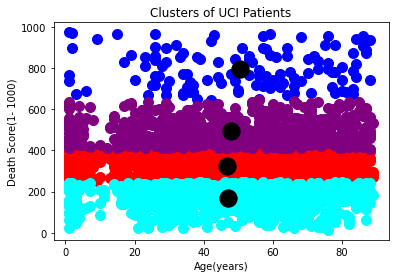

In [15]:
#predicting which cluster each data set belongs in
y_kmeans = kmeans.fit_predict(data_age_death)

#visualising the clusters
plt.scatter(data_age_death[y_kmeans == 0, 0], data_age_death[y_kmeans == 0, 1], s = 100, c= 'red', label = 'Cluster 1')
plt.scatter(data_age_death[y_kmeans == 1, 0], data_age_death[y_kmeans == 1, 1], s = 100, c= 'blue', label = 'Cluster 2')
plt.scatter(data_age_death[y_kmeans == 2, 0], data_age_death[y_kmeans == 2, 1], s = 100, c= 'purple', label = 'Cluster 3')
plt.scatter(data_age_death[y_kmeans == 3, 0], data_age_death[y_kmeans == 3, 1], s = 100, c= 'cyan', label = 'Cluster 4')
#plot the centroid. This will show the cluster centres with dataset points around them
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c= 'black', label = 'Centroids')
plt.title('Clusters of UCI Patients')
plt.xlabel('Age(years)')
plt.ylabel('Death Score(1- 1000)')
plt.show()
#organize into different cluster sets

CONCLUSION:
